In [1]:
import json, random, pathlib

random.seed(42)          # reproducibility

def make_student():
    """
    Simulate marks that drift slowly over time with some noise.
    """
    base = random.uniform(45, 95)          # long-term average for this student
    past = []
    for i in range(9):
        drift = 0.5 * (i + 1)              # gentle upward trend
        noise = random.gauss(0, 4)
        mark = base + drift + noise
        past.append(max(0, min(100, round(mark, 1))))

    # next term mark is based on the last few terms
    next_mark = past[-1] + random.gauss(1.5, 3)
    next_mark = max(0, min(100, round(next_mark, 1)))

    return {"past_9": past, "next_term": next_mark}

data = [make_student() for _ in range(100)]

# save to disk
pathlib.Path("student_marks.json").write_text(json.dumps(data, indent=2))

print("Dataset created: student_marks.json")
print("First sample:")
print(json.dumps(data[0], indent=2))

Dataset created: student_marks.json
First sample:
{
  "past_9": [
    80.6,
    78.5,
    79.6,
    85.4,
    75.7,
    72.4,
    84.0,
    83.1,
    84.2
  ],
  "next_term": 86.1
}


In [3]:
# train_and_predict.py
import json, numpy as np, tensorflow as tf
from tensorflow.keras import layers, models

# --------------------------------------------------
# 1. Load data
# --------------------------------------------------
with open("student_marks.json") as f:
    raw = json.load(f)

X = np.array([row["past_9"] for row in raw], dtype="float32")
y = np.array([row["next_term"] for row in raw], dtype="float32")

# --------------------------------------------------
# 2. Build & train model
# --------------------------------------------------
model = models.Sequential([
    layers.Input(shape=(9,)),
    layers.Dense(16, activation="relu"),
    layers.Dense(8,  activation="relu"),
    layers.Dense(1)                       # linear output
])

model.compile(optimizer="adam", loss="mse")
model.fit(X, y, epochs=200, verbose=0)

# --------------------------------------------------
# 3. Save model
# --------------------------------------------------
model.save("next_term_predictor.h5")
print("Model saved → next_term_predictor.h5")

# --------------------------------------------------
# 4. Inference on 5 new examples
# --------------------------------------------------
import random
random.seed(123)

def make_example():
    base = random.uniform(45, 95)
    past = []
    for i in range(9):
        mark = base + 0.5*(i+1) + random.gauss(0, 4)
        past.append(max(0, min(100, round(mark, 1))))
    next_true = max(0, min(100, round(past[-1] + random.gauss(1.5, 3), 1)))
    return np.array(past, dtype="float32"), next_true

examples = [make_example() for _ in range(5)]

print("\nPredictions vs. Truth:")
print("Example  Past_9 (last 3 terms shown)  Pred  True")
for idx, (vec, true_next) in enumerate(examples, 1):
    pred = model.predict(vec.reshape(1, -1), verbose=0)[0,0]
    print(f"{idx:>7}  {str(vec[-3:]):>23}  {pred:5.1f}  {true_next:4.1f}")

Model saved → next_term_predictor.h5

Predictions vs. Truth:
Example  Past_9 (last 3 terms shown)  Pred  True
      1         [47.3 58.4 54.1]   58.4  57.9
      2         [63.4 69.7 67.7]   70.5  68.5
      3         [56.  52.5 57.5]   57.5  57.1
      4         [76.7 74.2 75.7]   78.0  71.7
      5         [77.8 70.3 75.6]   76.7  79.5


Loading data...
Dataset shape: X=(100, 9), y=(100,)
Creating enhanced features...
Enhanced feature dimension: 18
Training enhanced model...
Epoch 1/300
1/2 ━━━━━━━━━━━━━━━━━━━━ 6s 6s/step - loss: 1.3691 - mae: 1.6681 - mse: 3.8543
Epoch 1: val_loss improved from inf to 0.25431, saving model to best_model_checkpoint.h5


2/2 ━━━━━━━━━━━━━━━━━━━━ 7s 586ms/step - loss: 1.3123 - mae: 1.6093 - mse: 3.7006 - val_loss: 0.2543 - val_mae: 0.3511 - val_mse: 0.1924 - learning_rate: 0.0010
Epoch 2/300
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 26ms/step - loss: 1.3090 - mae: 1.5780 - mse: 3.7789
Epoch 2: val_loss did not improve from 0.25431
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 80ms/step - loss: 1.1939 - mae: 1.4671 - mse: 3.2508 - val_loss: 0.2567 - val_mae: 0.3563 - val_mse: 0.1972 - learning_rate: 0.0010
Epoch 3/300
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 1.2598 - mae: 1.5528 - mse: 3.1676
Epoch 3: val_loss did not improve from 0.25431
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 78ms/step - loss: 1.0886 - mae: 1.3674 - mse: 2.5877 - val_loss: 0.2608 - val_mae: 0.3658 - val_mse: 0.2054 - learning_rate: 0.0010
Epoch 4/300
1/2 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step - loss: 1.0519 - mae: 1.3062 - mse: 2.6067
Epoch 4: val_loss did not improve from 0.25431
2/2 ━━━━━━━━━━━━━━━━━━━━ 0s 75ms/step - loss: 0.9352 - mae: 1.1845 - mse: 2.1625 - val_loss: 0.2631


Training Metrics:
  MSE: 198.3537
  RMSE: 14.0838
  MAE: 11.2610
  R²: 0.1793

Test Metrics:
  MSE: 149.8123
  RMSE: 12.2398
  MAE: 10.7521
  R²: 0.2568
Model and scalers saved to enhanced_next_term_predictor.h5

PREDICTION EXAMPLES
Example  Last 3 Terms        Predicted  Actual   Error
-------------------------------------------------------
      1  [66.12961 70.97047 70.99992]      75.7    71.0    4.71
      2  [65.289444 61.38098  64.66935 ]      75.5    62.1   13.41
      3  [68.07414 65.38986 72.72162]      75.6    69.8    5.77
      4  [56.71349  60.148304 63.327343]      76.7    65.7   11.01
      5  [57.603992 60.38673  64.74352 ]      77.2    67.0   10.21
      6  [58.892853 56.346603 61.08281 ]      76.5    63.8   12.72
      7  [78.62383  81.47356  87.197914]      80.2    86.4    6.20
      8  [54.13598  57.24483  53.969524]      77.0    52.9   24.06
      9  [55.93323  55.573887 59.758842]      77.5    60.7   16.79
     10  [70.50171 73.41665 75.08372]      75.4    73.3   

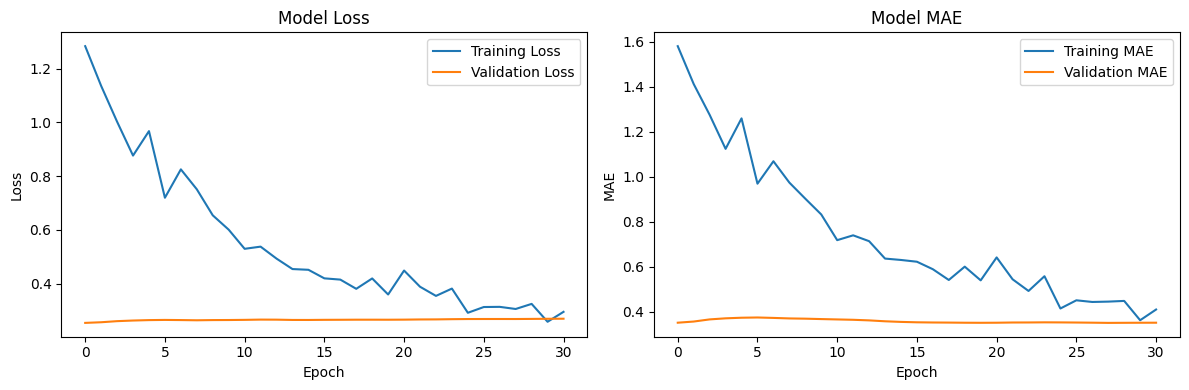


Training history plots saved as 'training_history.png'


In [ ]:
import json
import numpy as np
import tensorflow as tf
from tensorflow.keras import layers, models, callbacks, regularizers
from sklearn.preprocessing import StandardScaler, RobustScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
import matplotlib.pyplot as plt
import random
import warnings
warnings.filterwarnings('ignore')

# Set seeds for reproducibility
tf.random.set_seed(42)
np.random.seed(42)
random.seed(42)

class StudentPerformancePredictor:
    def __init__(self):
        self.model = None
        self.scaler_X = RobustScaler()  # More robust to outliers than StandardScaler
        self.scaler_y = RobustScaler()
        self.history = None

    def create_features(self, X):
        """Enhanced feature engineering"""
        features = []

        # Original sequence
        features.append(X)

        # Statistical features
        means = np.mean(X, axis=1, keepdims=True)
        stds = np.std(X, axis=1, keepdims=True)
        mins = np.min(X, axis=1, keepdims=True)
        maxs = np.max(X, axis=1, keepdims=True)

        features.extend([means, stds, mins, maxs])

        # Trend analysis
        # Linear trend (slope)
        time_steps = np.arange(X.shape[1]).reshape(1, -1)
        slopes = []
        for i in range(X.shape[0]):
            slope = np.polyfit(time_steps.flatten(), X[i], 1)[0]
            slopes.append(slope)
        slopes = np.array(slopes).reshape(-1, 1)
        features.append(slopes)

        # Recent performance (last 3 terms weighted more heavily)
        recent_avg = np.mean(X[:, -3:], axis=1, keepdims=True)
        features.append(recent_avg)

        # Performance volatility (coefficient of variation)
        cv = stds / (means + 1e-8)  # Add small epsilon to avoid division by zero
        features.append(cv)

        # Momentum (difference between recent and early performance)
        early_avg = np.mean(X[:, :3], axis=1, keepdims=True)
        momentum = recent_avg - early_avg
        features.append(momentum)

        # Improvement rate (change from first to last)
        improvement = (X[:, -1:] - X[:, :1])
        features.append(improvement)

        return np.concatenate(features, axis=1)

    def build_model(self, input_dim):
        """Build enhanced model with better architecture"""
        inputs = layers.Input(shape=(input_dim,))

        # Feature extraction with dropout and batch normalization
        x = layers.Dense(128, activation='relu',
                        kernel_regularizer=regularizers.l2(0.001))(inputs)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.3)(x)

        x = layers.Dense(64, activation='relu',
                        kernel_regularizer=regularizers.l2(0.001))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.2)(x)

        x = layers.Dense(32, activation='relu',
                        kernel_regularizer=regularizers.l2(0.001))(x)
        x = layers.BatchNormalization()(x)
        x = layers.Dropout(0.1)(x)

        x = layers.Dense(16, activation='relu')(x)

        # Output layer
        outputs = layers.Dense(1, activation='linear')(x)

        model = models.Model(inputs=inputs, outputs=outputs)

        # Use a more sophisticated optimizer with learning rate scheduling
        optimizer = tf.keras.optimizers.Adam(
            learning_rate=0.001,
            beta_1=0.9,
            beta_2=0.999,
            epsilon=1e-7
        )

        model.compile(
            optimizer=optimizer,
            loss='huber',  # More robust to outliers than MSE
            metrics=['mae', 'mse']
        )

        return model

    def train(self, X, y, validation_split=0.2, epochs=300):
        """Train the model with enhanced features and callbacks"""
        print("Creating enhanced features...")
        X_enhanced = self.create_features(X)

        print(f"Enhanced feature dimension: {X_enhanced.shape[1]}")

        # Scale features
        X_scaled = self.scaler_X.fit_transform(X_enhanced)
        y_scaled = self.scaler_y.fit_transform(y.reshape(-1, 1)).flatten()

        # Build model
        self.model = self.build_model(X_scaled.shape[1])

        # Callbacks for better training
        callbacks_list = [
            callbacks.EarlyStopping(
                monitor='val_loss',
                patience=30,
                restore_best_weights=True,
                verbose=1
            ),
            callbacks.ReduceLROnPlateau(
                monitor='val_loss',
                factor=0.5,
                patience=15,
                min_lr=1e-6,
                verbose=1
            ),
            callbacks.ModelCheckpoint(
                'best_model_checkpoint.h5',
                monitor='val_loss',
                save_best_only=True,
                verbose=1
            )
        ]

        print("Training enhanced model...")
        self.history = self.model.fit(
            X_scaled, y_scaled,
            epochs=epochs,
            validation_split=validation_split,
            batch_size=32,
            callbacks=callbacks_list,
            verbose=1
        )

        return self.history

    def predict(self, X):
        """Make predictions with feature engineering"""
        if self.model is None:
            raise ValueError("Model not trained yet!")

        X_enhanced = self.create_features(X)
        X_scaled = self.scaler_X.transform(X_enhanced)
        y_pred_scaled = self.model.predict(X_scaled, verbose=0)
        y_pred = self.scaler_y.inverse_transform(y_pred_scaled).flatten()

        # Ensure predictions are within valid range [0, 100]
        return np.clip(y_pred, 0, 100)

    def evaluate(self, X, y_true):
        """Comprehensive evaluation"""
        y_pred = self.predict(X)

        mse = mean_squared_error(y_true, y_pred)
        mae = mean_absolute_error(y_true, y_pred)
        r2 = r2_score(y_true, y_pred)

        return {
            'MSE': mse,
            'RMSE': np.sqrt(mse),
            'MAE': mae,
            'R²': r2
        }

    def save_model(self, filepath):
        """Save the complete model and scalers"""
        self.model.save(filepath)

        # Save scalers
        import joblib
        joblib.dump(self.scaler_X, filepath.replace('.h5', '_scaler_X.pkl'))
        joblib.dump(self.scaler_y, filepath.replace('.h5', '_scaler_y.pkl'))

        print(f"Model and scalers saved to {filepath}")

# --------------------------------------------------
# Main execution
# --------------------------------------------------
def main():
    # Load data
    print("Loading data...")
    with open("student_marks.json") as f:
        raw = json.load(f)

    X = np.array([row["past_9"] for row in raw], dtype="float32")
    y = np.array([row["next_term"] for row in raw], dtype="float32")

    print(f"Dataset shape: X={X.shape}, y={y.shape}")

    # Split data for proper validation
    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.2, random_state=42, shuffle=True
    )

    # Initialize and train model
    predictor = StudentPerformancePredictor()
    history = predictor.train(X_train, y_train, epochs=300)

    # Evaluate on test set
    print("\n" + "="*50)
    print("MODEL EVALUATION")
    print("="*50)

    train_metrics = predictor.evaluate(X_train, y_train)
    test_metrics = predictor.evaluate(X_test, y_test)

    print("\nTraining Metrics:")
    for metric, value in train_metrics.items():
        print(f"  {metric}: {value:.4f}")

    print("\nTest Metrics:")
    for metric, value in test_metrics.items():
        print(f"  {metric}: {value:.4f}")

    # Save enhanced model
    predictor.save_model("enhanced_next_term_predictor.h5")

    # Generate and evaluate examples
    print("\n" + "="*50)
    print("PREDICTION EXAMPLES")
    print("="*50)

    def make_realistic_example():
        """Generate more realistic student performance data"""
        # Start with a base performance level
        base = np.random.uniform(50, 90)

        # Add some natural progression/regression
        trend = np.random.uniform(-0.5, 1.0)  # Slight upward bias

        # Generate sequence with trend and noise
        past = []
        for i in range(9):
            # Base performance + trend + seasonal variation + noise
            seasonal = 3 * np.sin(i * np.pi / 4)  # Seasonal performance variation
            noise = np.random.normal(0, 3)
            mark = base + trend * i + seasonal + noise
            past.append(np.clip(mark, 0, 100))

        # Predict next term with some correlation to trend
        next_true = past[-1] + trend + np.random.normal(0, 2)
        next_true = np.clip(next_true, 0, 100)

        return np.array(past, dtype="float32"), next_true

    print("Example  Last 3 Terms        Predicted  Actual   Error")
    print("-" * 55)

    total_error = 0
    total_examples = 10

    for idx in range(1, total_examples + 1):
        past_marks, true_next = make_realistic_example()

        # Make prediction
        pred_next = predictor.predict(past_marks.reshape(1, -1))[0]
        error = abs(pred_next - true_next)
        total_error += error

        last_three = past_marks[-3:]
        print(f"{idx:>7}  {last_three}  {pred_next:8.1f}  {true_next:6.1f}  {error:6.2f}")

    avg_error = total_error / total_examples
    print("-" * 55)
    print(f"Average Prediction Error: {avg_error:.2f} marks")

    # Plot training history if available
    try:
        plt.figure(figsize=(12, 4))

        plt.subplot(1, 2, 1)
        plt.plot(history.history['loss'], label='Training Loss')
        plt.plot(history.history['val_loss'], label='Validation Loss')
        plt.title('Model Loss')
        plt.xlabel('Epoch')
        plt.ylabel('Loss')
        plt.legend()

        plt.subplot(1, 2, 2)
        plt.plot(history.history['mae'], label='Training MAE')
        plt.plot(history.history['val_mae'], label='Validation MAE')
        plt.title('Model MAE')
        plt.xlabel('Epoch')
        plt.ylabel('MAE')
        plt.legend()

        plt.tight_layout()
        plt.savefig('training_history.png', dpi=150, bbox_inches='tight')
        plt.show()
        print("\nTraining history plots saved as 'training_history.png'")

    except Exception as e:
        print(f"Could not generate plots: {e}")

if __name__ == "__main__":
    main()

In [ ]:
import os
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '2'

from flask import Flask, request, jsonify
from flask_cors import CORS
import numpy as np
import sqlite3
import hashlib
import jwt
import datetime
from functools import wraps
import tensorflow as tf

# Suppress TensorFlow warnings
tf.get_logger().setLevel('ERROR')

app = Flask(__name__)
CORS(app)
app.config['SECRET_KEY'] = 'asdadaiusdyau313123auidyayd123123'

# Load ML models
single_subject_model = tf.keras.models.load_model("next_term_predictor.h5", compile=False)

# Initialize database
def init_db():
   conn = sqlite3.connect('users.db')
   c = conn.cursor()
   c.execute('''CREATE TABLE IF NOT EXISTS users
                (id INTEGER PRIMARY KEY AUTOINCREMENT,
                 name TEXT NOT NULL,
                 age INTEGER NOT NULL,
                 grade TEXT NOT NULL,
                 email TEXT UNIQUE NOT NULL,
                 contact TEXT NOT NULL,
                 password TEXT NOT NULL)''')
   conn.commit()
   conn.close()

def hash_password(password):
   return hashlib.sha256(password.encode()).hexdigest()

def verify_token(f):
   @wraps(f)
   def decorated(*args, **kwargs):
       token = request.headers.get('Authorization')
       if not token:
           return jsonify({'message': 'Token missing'}), 401
       try:
           token = token.split(' ')[1]
           data = jwt.decode(token, app.config['SECRET_KEY'], algorithms=['HS256'])
       except:
           return jsonify({'message': 'Token invalid'}), 401
       return f(*args, **kwargs)
   return decorated

# Auth routes
@app.route('/register', methods=['POST'])
def register():
   data = request.get_json()
   conn = sqlite3.connect('users.db')
   c = conn.cursor()

   try:
       hashed_pw = hash_password(data['password'])
       c.execute("INSERT INTO users (name, age, grade, email, contact, password) VALUES (?, ?, ?, ?, ?, ?)",
                 (data['name'], data['age'], data['grade'], data['email'], data['contact'], hashed_pw))
       conn.commit()
       return jsonify({'message': 'User created successfully'}), 201
   except sqlite3.IntegrityError:
       return jsonify({'message': 'Email already exists'}), 400
   finally:
       conn.close()

@app.route('/login', methods=['POST'])
def login():
   data = request.get_json()
   conn = sqlite3.connect('users.db')
   c = conn.cursor()

   c.execute("SELECT * FROM users WHERE email = ?", (data['email'],))
   user = c.fetchone()
   conn.close()

   if user and user[6] == hash_password(data['password']):
       token = jwt.encode({
           'user_id': user[0],
           'exp': datetime.datetime.utcnow() + datetime.timedelta(hours=24)
       }, app.config['SECRET_KEY'])
       return jsonify({'token': token, 'user_id': user[0]})

   return jsonify({'message': 'Invalid credentials'}), 401

# User CRUD
@app.route('/users', methods=['GET'])
@verify_token
def get_users():
   conn = sqlite3.connect('users.db')
   c = conn.cursor()
   c.execute("SELECT id, name, age, grade, email, contact FROM users")
   users = [{'id': row[0], 'name': row[1], 'age': row[2], 'grade': row[3], 'email': row[4], 'contact': row[5]} for row in c.fetchall()]
   conn.close()
   return jsonify(users)

@app.route('/users/<int:user_id>', methods=['GET'])
@verify_token
def get_user(user_id):
   conn = sqlite3.connect('users.db')
   c = conn.cursor()
   c.execute("SELECT id, name, age, grade, contact FROM users WHERE id = ?", (user_id,))
   user = c.fetchone()
   conn.close()

   if user:
       return jsonify({'id': user[0], 'name': user[1], 'age': user[2], 'grade': user[3], 'email': user[4], 'contact': user[5]})
   return jsonify({'message': 'User not found'}), 404

@app.route('/users/<int:user_id>', methods=['PUT'])
@verify_token
def update_user(user_id):
   data = request.get_json()
   conn = sqlite3.connect('users.db')
   c = conn.cursor()

   if 'password' in data:
       data['password'] = hash_password(data['password'])
       c.execute("UPDATE users SET name=?, age=?, grade=?, email=?, contact=?, password=? WHERE id=?",
                 (data['name'], data['age'], data['grade'], data['email'], data['contact'], data['password'], user_id))
   else:
       c.execute("UPDATE users SET name=?, age=?, grade=?, email=?, contact=? WHERE id=?",
                 (data['name'], data['age'], data['grade'], data['email'], data['contact'], user_id))

   conn.commit()
   conn.close()
   return jsonify({'message': 'User updated successfully'})

@app.route('/users/<int:user_id>', methods=['DELETE'])
@verify_token
def delete_user(user_id):
   conn = sqlite3.connect('users.db')
   c = conn.cursor()
   c.execute("DELETE FROM users WHERE id = ?", (user_id,))
   conn.commit()
   conn.close()
   return jsonify({'message': 'User deleted successfully'})

# ML Prediction routes
@app.route('/predict/single', methods=['POST'])
@verify_token
def predict_single():
   data = request.get_json()
   marks = np.array(data['marks'], dtype="float32").reshape(1, -1)
   prediction = single_subject_model.predict(marks, verbose=0)
   return jsonify({'prediction': float(prediction[0][0])})

@app.route('/predict/multi', methods=['POST'])
@verify_token
def predict_multi():
   data = request.get_json()
   marks = np.array(data['marks'], dtype="float32")

   if len(marks) != 81:
       return jsonify({'error': 'Expected 81 marks (9 subjects x 9 terms)'}), 400

   predictions = []
   for subject in range(9):
       start_idx = subject * 9
       end_idx = start_idx + 9
       subject_marks = marks[start_idx:end_idx].reshape(1, -1)
       prediction = single_subject_model.predict(subject_marks, verbose=0)
       predictions.append(float(prediction[0][0]))

   return jsonify({'predictions': predictions, 'average': float(np.mean(predictions))})

if __name__ == '__main__':
   init_db()
   app.run(debug=True)

# Student Management & ML Prediction API

## Base URL
```
http://localhost:5000
```

## Authentication
Most endpoints require JWT token authentication. Include the token in the Authorization header:
```
Authorization: Bearer <your_jwt_token>
```

---

## Authentication Endpoints

### Register User
**POST** `/register`

Create a new user account.

**Request Body:**
```json
{
  "name": "John Doe",
  "age": 18,
  "grade": "Grade 12",
  "email": "john@example.com",
  "contact": "+1234567890",
  "password": "securepassword"
}
```

**Response:**
```json
{
  "message": "User created successfully"
}
```

**Status Codes:**
- `201` - User created successfully
- `400` - Email already exists

---

### Login
**POST** `/login`

Authenticate user and receive JWT token.

**Request Body:**
```json
{
  "email": "john@example.com",
  "password": "securepassword"
}
```

**Response:**
```json
{
  "token": "eyJ0eXAiOiJKV1QiLCJhbGciOiJIUzI1NiJ9...",
  "user_id": 1
}
```

**Status Codes:**
- `200` - Login successful
- `401` - Invalid credentials

---

## User Management Endpoints

### Get All Users
**GET** `/users`

Retrieve all users (requires authentication).

**Response:**
```json
[
  {
    "id": 1,
    "name": "John Doe",
    "age": 18,
    "grade": "Grade 12",
    "email": "john@example.com",
    "contact": "+1234567890"
  }
]
```

---

### Get User by ID
**GET** `/users/{user_id}`

Retrieve specific user details (requires authentication).

**Response:**
```json
{
  "id": 1,
  "name": "John Doe",
  "age": 18,
  "grade": "Grade 12",
  "email": "john@example.com",
  "contact": "+1234567890"
}
```

**Status Codes:**
- `200` - User found
- `404` - User not found

---

### Update User
**PUT** `/users/{user_id}`

Update user information (requires authentication).

**Request Body:**
```json
{
  "name": "John Updated",
  "age": 19,
  "grade": "Grade 12",
  "email": "john.updated@example.com",
  "contact": "+1234567891",
  "password": "newpassword"
}
```

**Response:**
```json
{
  "message": "User updated successfully"
}
```

---

### Delete User
**DELETE** `/users/{user_id}`

Delete a user (requires authentication).

**Response:**
```json
{
  "message": "User deleted successfully"
}
```

---

## ML Prediction Endpoints

### Single Subject Prediction
**POST** `/predict/single`

Predict next term marks for a single subject (requires authentication).

**Request Body:**
```json
{
  "marks": [75.2, 76.8, 78.1, 79.5, 80.2, 81.7, 82.9, 84.1, 85.3]
}
```

**Response:**
```json
{
  "prediction": 86.7
}
```

**Notes:**
- Expects exactly 9 marks (past 9 terms for one subject)
- Returns predicted mark for next term

---

### Multi Subject Prediction
**POST** `/predict/multi`

Predict average marks for next term across all subjects (requires authentication).

**Request Body:**
```json
{
  "marks": [
    75.2, 76.8, 78.1, 79.5, 80.2, 81.7, 82.9, 84.1, 85.3,
    72.5, 74.2, 75.8, 77.1, 78.5, 79.9, 81.2, 82.6, 84.0,
    80.1, 81.5, 82.3, 83.7, 84.9, 85.8, 86.5, 87.2, 88.1,
    ...
  ]
}
```

**Response:**
```json
{
  "prediction": 85.4
}
```

**Notes:**
- Expects exactly 81 marks (9 subjects × 9 terms)
- Order: [Subject1_Term1, Subject1_Term2, ..., Subject1_Term9, Subject2_Term1, ..., Subject9_Term9]
- Returns predicted average mark for next term

**Status Codes:**
- `200` - Prediction successful
- `400` - Invalid number of marks provided

---

## Error Responses

### Authentication Error
```json
{
  "message": "Token missing"
}
```
**Status Code:** `401`

### Invalid Token
```json
{
  "message": "Token invalid"
}
```
**Status Code:** `401`

### Validation Error
```json
{
  "error": "Expected 81 marks (9 subjects x 9 terms)"
}
```
**Status Code:** `400`

---

## Data Models

### User Model
```json
{
  "id": "integer (auto-generated)",
  "name": "string (required)",
  "age": "integer (required)",
  "grade": "string (required)",
  "email": "string (required, unique)",
  "contact": "string (required)",
  "password": "string (required, hashed)"
}
```

### Single Subject Marks
Array of 9 float values representing marks for past 9 terms.

### Multi Subject Marks
Array of 81 float values representing marks for 9 subjects over 9 terms.
Format: [S1T1, S1T2, ..., S1T9, S2T1, S2T2, ..., S2T9, ..., S9T1, S9T2, ..., S9T9]

Where:
- S = Subject (1-9)
- T = Term (1-9)

---

## Setup Instructions

1. Install dependencies:
```bash
pip install -r requirements.txt
```

2. Run the application:
```bash
python app.py
```

3. Ensure pickle files are present:
   - `predictor.pkl` (single subject model)
   - `multi_subject_predictor.pkl` (multi subject model)

4. Database (`users.db`) will be created automatically on first run.

---

## Notes

- JWT tokens expire after 24 hours
- All predictions require authentication
- Database uses SQLite for simplicity
- CORS is enabled for all origins
- Passwords are hashed using SHA-256

Flask==2.3.3
Flask-CORS==4.0.0
numpy==1.24.3
PyJWT==2.8.0
tensorflow==2.13.0